## Required Modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
from sklearn import svm

import os
import datetime as dt
from sklearn.model_selection import GridSearchCV

!pip install -q diptest
from diptest import diptest

import warnings
warnings.filterwarnings('error', category=RuntimeWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 7.6 MB/s eta 0:00:00


## Global Variables

In [2]:
TRN_DATA_PATH = "/kaggle/input/184-702-tu-ml-2025-w-loan/loan-10k.lrn.csv"
TST_DATA_PATH = "/kaggle/input/184-702-tu-ml-2025-w-loan/loan-10k.tes.csv"

ID = "ID"
LABEL = "grade"
UNUSED = ["policy_code"]

SEED = 12531554

## Data Ingestion

In [3]:
df_raw_trn = pd.read_csv(TRN_DATA_PATH)
df_raw_tst = pd.read_csv(TST_DATA_PATH)

print(df_raw_trn.shape)
print(df_raw_tst.shape)

N = df_raw_trn.shape[0]
print(set(df_raw_trn.columns) - set(df_raw_tst.columns))

(10000, 92)
(10000, 91)
{'grade'}


Get unique `LABEL` values:

In [4]:
class_labels = df_raw_trn[LABEL].unique().tolist()
class_labels.sort()
print(class_labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G']


### Check Numerical Features

Identified $1$ column with constant value.

In [5]:
for column, dtype in zip(df_raw_trn.columns, df_raw_trn.dtypes):
    unique = df_raw_trn[column].nunique(dropna=False)
    if unique == 1:
        print(f"{column}  {str(dtype)}  {unique}")

df_use_trn = df_raw_trn.drop(columns=["policy_code"])

policy_code  float64  1


No `null` values found.

In [6]:
numeric_columns = df_use_trn.select_dtypes(
    include=np.number).columns.tolist()

numeric_columns.remove(ID)
print(len(numeric_columns))

x_numeric = df_use_trn[numeric_columns]
y = df_use_trn[[LABEL]]

IQR = "Inter-Quartile Range"
ZSC = "Z-Scores"
ISF = "Isolation Forest"

outlier_masks = {
    IQR: {},
    ZSC: {},
    ISF: {}}

76


In [7]:
tst_missing_values = df_use_trn.isna().sum()
print(tst_missing_values[tst_missing_values > 0])

trn_missing_values = df_use_trn.isna().sum()
print(trn_missing_values[trn_missing_values > 0])

Series([], dtype: int64)
Series([], dtype: int64)


Isolating numeric features and identifying outliers with **Inter-Quartile Range**, **Z-Score**, and **Isolation Forest**.

Check if feature is normal, skewed, or multi-modal. For features that are not multi-modal, all seem to be skewed so no Z-Scores will be used.

In [8]:
def is_normal(series: pd.Series, alpha: float=0.01) -> bool:
    _, p = stats.normaltest(series)
    return p > alpha


def is_skewed(series: pd.Series, alpha: float=0.01) -> bool:
    _, p = stats.skewtest(series)
    return p < alpha


def is_multimodal(series: pd.Series, alpha: float=0.01) -> bool:
    _, p = diptest(series)
    return p < alpha


assign_method = {
    IQR: [],
    ZSC: [],
    ISF: []}

for column in numeric_columns:
    normal = is_normal(x_numeric[column])
    skewed = is_skewed(x_numeric[column])
    multimodal = is_multimodal(x_numeric[column], 0.01)
    
    if multimodal:
        assign_method[ISF].append(column)
    elif normal and not skewed:
        assign_method[ZSC].append(column)
    else:
        assign_method[IQR].append(column)

for method in assign_method:
    print(f"{method}: {len(assign_method[method])}")

Inter-Quartile Range: 27
Z-Scores: 0
Isolation Forest: 49


Flag outliers using IQR.

In [9]:
for column in assign_method[IQR]:
    iqr_mask = pd.Series(False, index=df_use_trn.index)
    
    q1 = x_numeric[column].quantile(0.25)
    q3 = x_numeric[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    lower_mask = (x_numeric[column] < lower_bound)
    upper_mask = (x_numeric[column] > upper_bound)
    
    iqr_mask = lower_mask | upper_mask
    
    outlier_masks[IQR][column] = iqr_mask

Flag outliers using Isolation Forest.

In [10]:
CONTAMINATION = 0.05

for column in assign_method[ISF]:

    isf = IsolationForest(
        n_estimators=100,
        max_samples="auto",
        contamination=CONTAMINATION,
        random_state=SEED)
    
    isf.fit(x_numeric[[column]].values)
    predictions = isf.predict(x_numeric[[column]].values)
    isf_mask = pd.Series(predictions == -1, index=df_use_trn.index)

    outlier_masks[ISF][column] = isf_mask

Visual check of outliers.

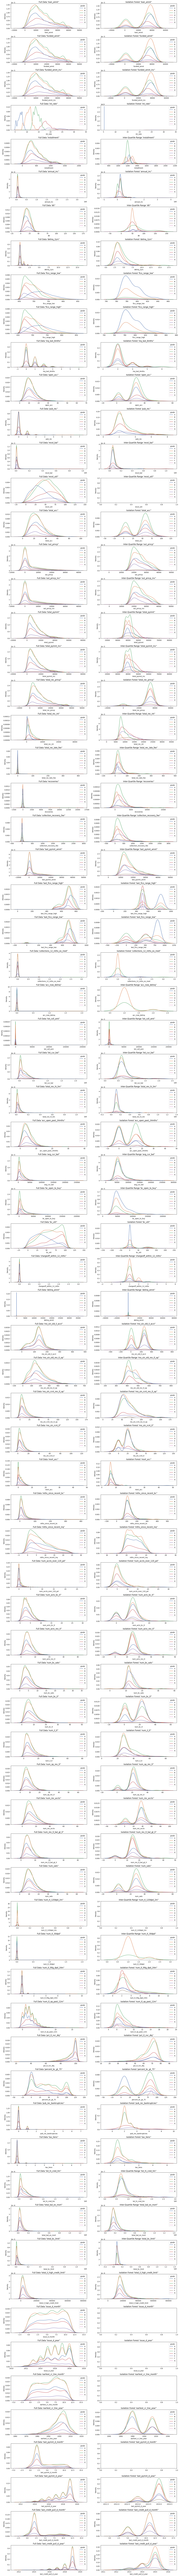

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    warnings.simplefilter("ignore", UserWarning)

    base_palette = sns.color_palette("deep", n_colors=len(class_labels))
    palette_dict = dict(zip(class_labels, base_palette))
    
    plot_columns = 2
    plot_rows = len(numeric_columns)
    
    figures, axes = plt.subplots(
        plot_rows,
        plot_columns,
        figsize=(plot_columns * 8, plot_rows * 3),
        constrained_layout=True)
    
    axes = axes.reshape(-1, plot_columns)
    
    for i, column in enumerate(numeric_columns):
        
        ax_full = axes[i, 0]
        sns.kdeplot(
            data=df_use_trn,
            x=column,
            hue=LABEL,
            hue_order=class_labels,
            palette=palette_dict,
            ax=ax_full)
        ax_full.set_title(f"Full Data '{column}''")

        method = IQR if column in outlier_masks[IQR] else ISF
        mask = outlier_masks[method][column]

        ax_mask = axes[i, 1]
        sns.kdeplot(
            data=df_use_trn[mask],
            x=column,
            hue=LABEL,
            hue_order=class_labels,
            palette=palette_dict,
            ax=ax_mask)
        ax_mask.set_title(f"{method} '{column}''")
    
    plt.tight_layout()

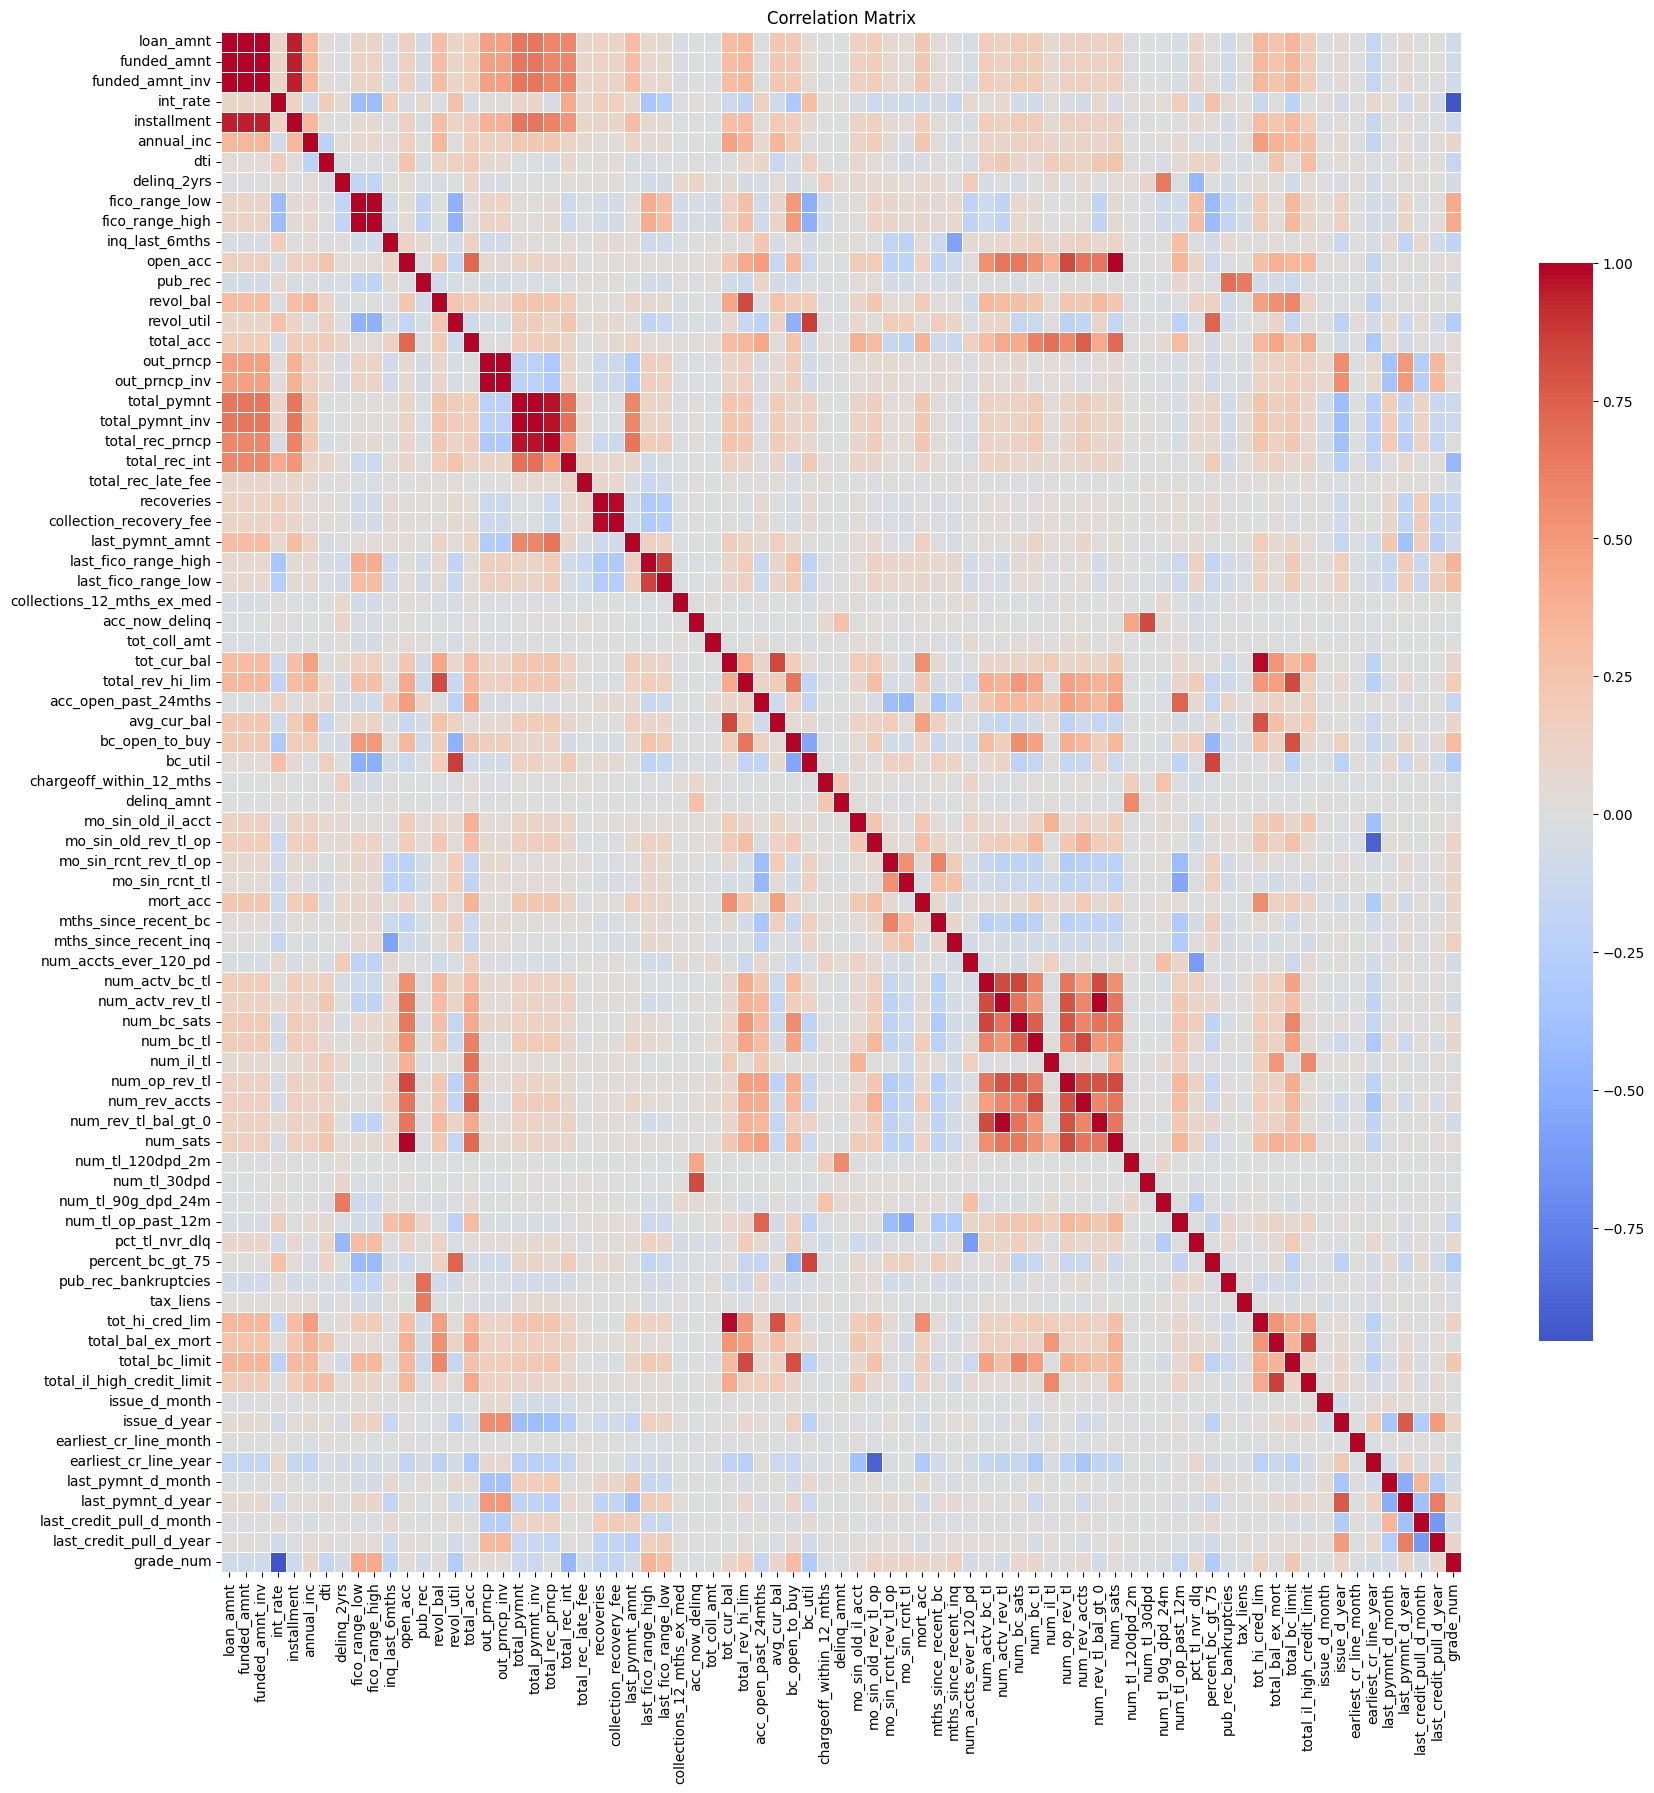

In [12]:
df_correlation = df_use_trn.copy()

label_to_int = {
    grade: i for
    i, grade in enumerate(
        reversed(class_labels),
        start=1)}

df_correlation["grade_num"] = df_correlation[LABEL].map(label_to_int)

df_numeric = df_correlation.select_dtypes(
    include=np.number).drop(columns=[ID])

correlation_matrix = df_numeric.corr()
# display(correlation_matrix)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        correlation_matrix,
        # annot=True,
        # fmt=".2f",
        cmap="coolwarm",
        center=0.0,
        linewidth=0.5,
        cbar_kws={"shrink": .7})
    
    plt.title("Correlation Matrix")
    plt.show()

### Check Non-Numerical Features

Encode non-numerical values into meaningful numerical features.

In [13]:
non_numeric_columns = df_use_trn.select_dtypes(
    exclude=np.number).drop(columns=[LABEL]).columns.tolist()
print(non_numeric_columns)

['term', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


Make numeric `term_months` from `term`.

In [14]:
def term_to_numeric(series: pd.Series) -> pd.Series:
    return series.str.extract(r"(\d+)").astype(int)


df_numeric["term_months"] = term_to_numeric(df_use_trn["term"])
print(df_numeric["term_months"].describe())

if "term" in non_numeric_columns:
    non_numeric_columns.remove("term")

count    10000.000000
mean        43.360800
std         11.067523
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: term_months, dtype: float64


Make numeric `emp_len_years` from `emp_length`.

In [15]:
def emp_length_to_numeric(series: pd.Series) -> pd.Series:
    new_series = series.str.extract(r"(\d+)", expand=False).astype(float)
    new_series[series.str.contains(r"<")] = 0.5
    new_series[series.str.contains(r"\+")] = 10
    return new_series


df_numeric["emp_len_years"] = emp_length_to_numeric(df_use_trn["emp_length"])
print(df_numeric["emp_len_years"].describe())

if "emp_length" in non_numeric_columns:
    non_numeric_columns.remove("emp_length")

count    10000.000000
mean         6.009150
std          3.627231
min          0.500000
25%          2.000000
50%          6.000000
75%         10.000000
max         10.000000
Name: emp_len_years, dtype: float64


One-hot encoding for `home_ownership`.

In [16]:
def home_ownership_to_onehot(series: pd.Series) -> pd.DataFrame:
    series = series.replace("NONE", "OTHER")
    dummies = pd.get_dummies(series, prefix='home')
    dummies = dummies.rename(columns=str.lower)
    return dummies


if "home_own" not in df_numeric.columns:
    home_ownership_onehot = home_ownership_to_onehot(
        df_use_trn["home_ownership"])
    print(home_ownership_onehot.columns)
    df_numeric = pd.concat([df_numeric, home_ownership_onehot], axis=1)

if "home_ownership" in non_numeric_columns:
    non_numeric_columns.remove("home_ownership")

Index(['home_any', 'home_mortgage', 'home_other', 'home_own', 'home_rent'], dtype='object')


Make ordinal `verf_status_num` from `verification_status`.

In [17]:
def verification_status_to_ordinal(series: pd.Series) -> pd.Series:
    status_order = {
        "Not Verified": 0,
        "Source Verified": 1,
        "Verified": 2}
    return series.map(status_order)


df_numeric["verf_status_num"] = verification_status_to_ordinal(
    df_use_trn["verification_status"])
print(df_numeric["verf_status_num"].describe())

if "verification_status" in non_numeric_columns:
    non_numeric_columns.remove("verification_status")

count    10000.000000
mean         0.924200
std          0.755057
min          0.000000
25%          0.000000
50%          1.000000
75%          1.250000
max          2.000000
Name: verf_status_num, dtype: float64


Make ordinal `loan_status_num` from `loan_status`.

In [18]:
def loan_status_to_ordinal(series: pd.Series) -> pd.Series:
    status_order = {
        "Fully Paid": 0,
        "Current": 1,
        "In Grace Period": 2,
        "Late (16-30 days)": 3,
        "Late (31-120 days)": 4,
        "Charged Off": 5}
    return series.map(status_order)

df_numeric["loan_status_num"] = loan_status_to_ordinal(
    df_use_trn["loan_status"])
print(df_numeric["loan_status_num"].describe())

if "loan_status" in non_numeric_columns:
    non_numeric_columns.remove("loan_status")

count    10000.000000
mean         1.026400
std          1.552077
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: loan_status_num, dtype: float64


Make numerical `pymnt_plan_num` from `pymnt_plan`.

In [19]:
def pymnt_plan_to_ordinal(series: pd.Series) -> pd.Series:
    return series.map({"n": 0, "y": 1})

df_numeric["pymnt_plan_num"] = pymnt_plan_to_ordinal(
    df_use_trn["pymnt_plan"])
print(df_numeric["pymnt_plan_num"].describe())

if "pymnt_plan" in non_numeric_columns:
    non_numeric_columns.remove("pymnt_plan")

count    10000.000000
mean         0.000500
std          0.022356
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pymnt_plan_num, dtype: float64


One-hot encoding for `purpose`.

In [20]:
def purpose_to_onehot(series: pd.Series) -> pd.DataFrame:
    dummies = pd.get_dummies(series, prefix='purpose')
    return dummies


if "purpose_car" not in df_numeric.columns:
    purpose_onehot = purpose_to_onehot(
        df_use_trn["purpose"])
    df_numeric = pd.concat([df_numeric, purpose_onehot], axis=1)
    
if "purpose" in non_numeric_columns:
    non_numeric_columns.remove("purpose")

Make frequency and label encoding `addr_state_num` from `addr_state`.

In [21]:
def addr_state_to_encoding(
        state_series: pd.Series,
        label_series: pd.Series,
        encode_series: pd.Series) -> pd.Series:
    grade_counts_A = (label_series == "A").groupby(state_series).sum() / 10000
    grade_counts_B = (label_series == "B").groupby(state_series).sum() / 10000
    grade_counts_C = (label_series == "C").groupby(state_series).sum() / 10000
    grade_counts = grade_counts_A + grade_counts_B + grade_counts_C
    
    state_counts = state_series.value_counts()
    encoding = dict(state_counts * grade_counts)
    return encode_series.map(encoding)


df_numeric["addr_state_num"] = addr_state_to_encoding(
    df_use_trn["addr_state"],
    df_use_trn[LABEL],
    df_use_trn["addr_state"])
print(df_numeric["addr_state_num"].nunique())
print(df_numeric["addr_state_num"].describe())

if "addr_state" in non_numeric_columns:
    non_numeric_columns.remove("addr_state")

50
count    10000.000000
mean        32.672429
std         45.787407
min          0.020400
25%          2.659800
50%          8.475500
75%         42.187200
max        140.239000
Name: addr_state_num, dtype: float64


Make numeric `init_lst_status_num` from `initial_list_status`.

In [22]:
def initial_list_status_to_ordinal(series: pd.Series) -> pd.Series:
    return series.map({"w": 0, "f": 1})


df_numeric["init_lst_status_num"] = initial_list_status_to_ordinal(
    df_use_trn["initial_list_status"])
print(df_numeric["init_lst_status_num"].describe())

if "initial_list_status" in non_numeric_columns:
    non_numeric_columns.remove("initial_list_status") 

count    10000.000000
mean         0.296300
std          0.456648
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: init_lst_status_num, dtype: float64


Make numerical `app_type_num` from `application_type`.

In [23]:
def application_type_to_ordinal(series: pd.Series) -> pd.Series:
    return series.map({"Individual": 1, "Joint App": 2})


df_numeric["app_type_num"] = application_type_to_ordinal(
    df_use_trn["application_type"])
print(df_numeric["app_type_num"].describe())

if "application_type" in non_numeric_columns:
    non_numeric_columns.remove("application_type")

count    10000.000000
mean         1.054200
std          0.226423
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: app_type_num, dtype: float64


Make `hardship_flag` numerical.

In [24]:
def hardship_flag_to_boolean(series: pd.Series) -> pd.Series:
    return series.map({"N": 0, "Y": 1})


df_numeric["hardship_flag"] = hardship_flag_to_boolean(
    df_use_trn["hardship_flag"])
print(df_numeric["hardship_flag"].describe())

if "hardship_flag" in non_numeric_columns:
    non_numeric_columns.remove("hardship_flag")

count    10000.000000
mean         0.000600
std          0.024489
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: hardship_flag, dtype: float64


Make numerical `disbursement_method_num` from `disbursement_method`.

In [25]:
def disbursement_method_to_ordinal(series: pd.Series) -> pd.Series:
    return series.map({"Cash": -1, "DirectPay": 1})


df_numeric["disbursement_method_num"] = disbursement_method_to_ordinal(
    df_use_trn["disbursement_method"])
print(df_numeric["disbursement_method_num"].describe())

if "disbursement_method" in non_numeric_columns:
    non_numeric_columns.remove("disbursement_method")

count    10000.000000
mean        -0.926000
std          0.377542
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max          1.000000
Name: disbursement_method_num, dtype: float64


Make `debt_settlement_flag` numerical.

In [26]:
def debt_settlement_flag_to_boolean(series: pd.Series) -> pd.Series:
    return series.map({"N": 0, "Y": 1})


df_numeric["debt_settlement_flag"] = debt_settlement_flag_to_boolean(
    df_use_trn["debt_settlement_flag"])
print(df_numeric["debt_settlement_flag"].describe())

if "debt_settlement_flag" in non_numeric_columns:
    non_numeric_columns.remove("debt_settlement_flag")

count    10000.000000
mean         0.018000
std          0.132958
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: debt_settlement_flag, dtype: float64


### Data Cleaning Method

In [27]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:

    # Remove constant value columns
    to_remove = UNUSED
    new_df = df.drop(columns=to_remove)

    # Keep only numerical columns
    new_df = new_df[numeric_columns]

    # Make numerical features
    new_df["term_months"] = term_to_numeric(df["term"])
    new_df["emp_len_years"] = emp_length_to_numeric(df["emp_length"])
    new_df["verf_status_num"] = verification_status_to_ordinal(df["verification_status"])
    new_df["loan_status_num"] = loan_status_to_ordinal(df["loan_status"])
    new_df["pymnt_plan_num"] = pymnt_plan_to_ordinal(df["pymnt_plan"])
    new_df["init_lst_status_num"] = initial_list_status_to_ordinal(df["initial_list_status"])
    new_df["app_type_num"] = application_type_to_ordinal(df["application_type"])
    new_df["hardship_flag"] = hardship_flag_to_boolean(df["hardship_flag"])
    new_df["disbursement_method_num"] = disbursement_method_to_ordinal(df["disbursement_method"])
    new_df["debt_settlement_flag"] = debt_settlement_flag_to_boolean(df["debt_settlement_flag"])
    
    new_df["addr_state_num"] = addr_state_to_encoding(
        df_raw_trn["addr_state"],
        df_raw_trn[LABEL],
        df["addr_state"])

    home_ownership_onehot = home_ownership_to_onehot(df["home_ownership"])
    purpose_onehot = purpose_to_onehot(df["purpose"])
    new_df = pd.concat([new_df, home_ownership_onehot, purpose_onehot], axis=1)

    return pd.concat([new_df, df[ID]], axis=1)

## Modeling

Prepare and partition datasets.

In [28]:
%%time

PARTITION_RATIO = 0.7
SEEDS = [1, 7, 42, 100, 120, 123, 666, 100000]


def prepare_cv_datasets(
        df: pd.DataFrame,
        seeds: List[int]=SEEDS,
        label: str=LABEL
    ) -> Tuple[List[Tuple[pd.DataFrame, pd.DataFrame]], List[Tuple[pd.DataFrame, pd.DataFrame]]]:
    
    train_cv_dfs = []
    test_cv_dfs = []
    
    for seed in seeds:

        # Split into train and test
        df_train, df_test = train_test_split(
            df,
            train_size=PARTITION_RATIO,
            random_state=seed)

        # Separate label
        X_train, y_train = df_train.drop([ID, label], axis=1), df_train[label]
        X_test, y_test = df_test.drop([ID, label], axis=1), df_test[label]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        train_cv_dfs.append((X_train, y_train))
        test_cv_dfs.append((X_test, y_test))

    return train_cv_dfs, test_cv_dfs


df = clean_data(df_raw_trn)
df[LABEL] = df_raw_trn[LABEL]
# print(df.columns[df.isna().any()].tolist())

label_to_int = {
grade: i for
i, grade in enumerate(
    reversed(class_labels))}
df[LABEL] = df_raw_trn[LABEL].map(label_to_int)

train_cv_dfs, test_cv_dfs = prepare_cv_datasets(df)

metrics = {
    "Baseline": {},
    "": {}}
step = "Baseline"

CPU times: user 732 ms, sys: 129 ms, total: 861 ms
Wall time: 706 ms


Method to print performance.

In [29]:
def display_performance(performance: np.ndarray[np.float64], label: str) -> None:
    display(pd.DataFrame({
        f"{label} Precision": [performance[0]],
        f"{label} Recall": [performance[1]],
        f"{label} F1": [performance[2]]}))

### Logistic Regression

Training Precision  Training Recall  Training F1
0            0.877681         0.818013     0.842823

Test Precision  Test Recall   Test F1
0        0.877681     0.818013  0.842823

CPU times: user 2min 2s, sys: 88.3 ms, total: 2min 2s
Wall time: 31.2 s


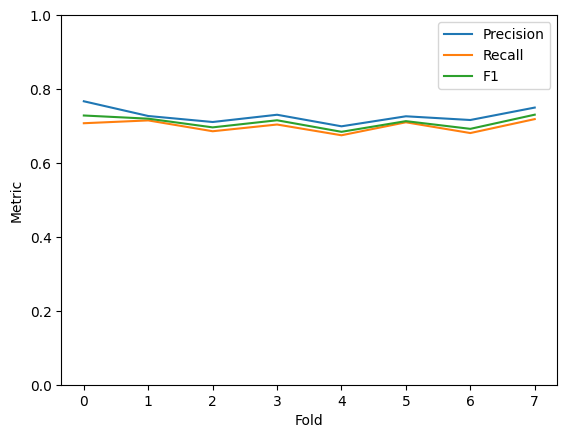

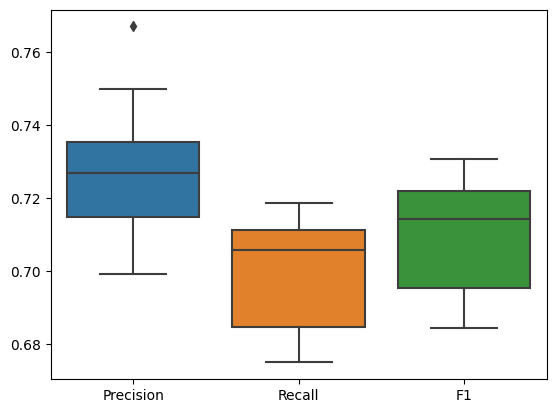

In [31]:
%%time

train_performance_lgr = np.empty((len(SEEDS), 4))
test_performance_lgr = np.empty((len(SEEDS), 4))

for i, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    logistic_regression = LogisticRegression(
        random_state=SEED, max_iter=1000)
    logistic_regression.fit(X_train, y_train)

    y_train_pred = logistic_regression.predict(X_train)
    y_test_pred = logistic_regression.predict(X_test)

    train_fold_performance = precision_recall_fscore_support(
        y_train, y_train_pred, average="macro")
    test_fold_performance = precision_recall_fscore_support(
        y_test, y_test_pred, average="macro")
    
    train_performance_lgr[i] = train_fold_performance
    test_performance_lgr[i] = test_fold_performance

train_performance_lgr_mean = train_performance_lgr.mean(axis=0)
test_performance_lgr_mean = train_performance_lgr.mean(axis=0)
display_performance(train_performance_lgr_mean, label="Training")
display_performance(test_performance_lgr_mean, label="Test")

plt.plot(test_performance_lgr[:, 0], label="Precision")
plt.plot(test_performance_lgr[:, 1], label="Recall")
plt.plot(test_performance_lgr[:, 2], label="F1")
plt.xticks(range(test_performance_lgr.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.legend()

plt.figure()
ax = sns.boxplot(test_performance_lgr[:, :-1])
ax.set_xticklabels(["Precision", "Recall", "F1"])
ticks = plt.xticks()[0]

metrics[step]["LogisticRegression"] = {}
metrics[step]["LogisticRegression"]["Train"] = tuple(train_performance_lgr_mean)
metrics[step]["LogisticRegression"]["Test"] = tuple(test_performance_lgr_mean)

### XGBoost

Training Precision  Training Recall  Training F1
0                 1.0              1.0          1.0

Test Precision  Test Recall   Test F1
0        0.901791      0.88875  0.891005

CPU times: user 1min 1s, sys: 426 ms, total: 1min 1s
Wall time: 15.8 s


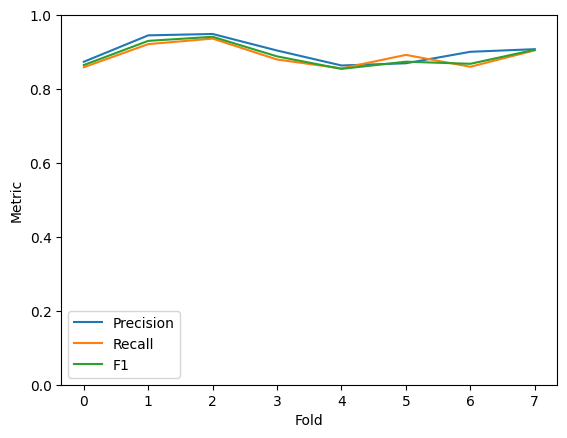

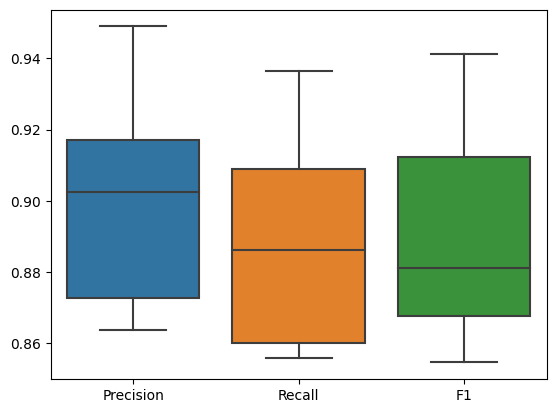

In [32]:
%%time

train_performance_xgb = np.empty((len(SEEDS), 4))
test_performance_xgb = np.empty((len(SEEDS), 4))

for i, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    gradient_boosting = XGBClassifier(random_state=SEED)
    gradient_boosting.fit(X_train, y_train)

    y_train_pred = gradient_boosting.predict(X_train)
    y_test_pred = gradient_boosting.predict(X_test)

    train_fold_performance = precision_recall_fscore_support(
        y_train, y_train_pred, average="macro")
    test_fold_performance = precision_recall_fscore_support(
        y_test, y_test_pred, average="macro")
    
    train_performance_xgb[i] = train_fold_performance
    test_performance_xgb[i] = test_fold_performance

train_performance_xgb_mean = train_performance_xgb.mean(axis=0)
test_performance_xgb_mean = test_performance_xgb.mean(axis=0)
display_performance(train_performance_xgb_mean, label="Training")
display_performance(test_performance_xgb_mean, label="Test")

plt.plot(test_performance_xgb[:, 0], label="Precision")
plt.plot(test_performance_xgb[:, 1], label="Recall")
plt.plot(test_performance_xgb[:, 2], label="F1")
plt.xticks(range(test_performance_xgb.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.legend()

plt.figure()
ax = sns.boxplot(test_performance_xgb[:, :-1])
ax.set_xticklabels(["Precision", "Recall", "F1"])
ticks = plt.xticks()[0]

metrics[step]["GradientBoosting"] = {}
metrics[step]["GradientBoosting"]["Train"] = tuple(train_performance_xgb_mean)
metrics[step]["GradientBoosting"]["Test"] = tuple(test_performance_xgb_mean)

### Support Vector Machine

Training Precision  Training Recall  Training F1
0            0.926838          0.94215     0.934055

Test Precision  Test Recall   Test F1
0        0.629406     0.602512  0.606319

CPU times: user 1min 39s, sys: 372 ms, total: 1min 39s
Wall time: 1min 39s


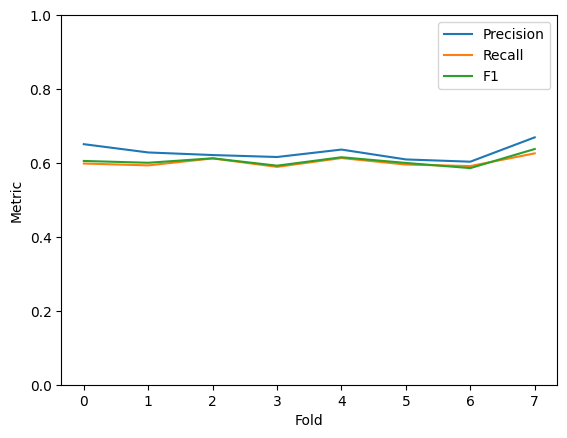

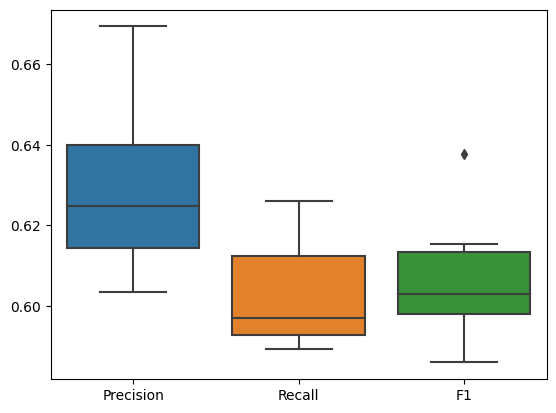

In [33]:
%%time

train_performance_svm = np.empty((len(SEEDS), 4))
test_performance_svm = np.empty((len(SEEDS), 4))

for i, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    svm_classifier = svm.SVC(random_state=SEED, class_weight="balanced")
    svm_classifier.fit(X_train, y_train)

    y_train_pred = svm_classifier.predict(X_train)
    y_test_pred = svm_classifier.predict(X_test)

    train_fold_performance = precision_recall_fscore_support(
        y_train, y_train_pred, average="macro")
    test_fold_performance = precision_recall_fscore_support(
        y_test, y_test_pred, average="macro")
    
    train_performance_svm[i] = train_fold_performance
    test_performance_svm[i] = test_fold_performance

train_performance_svm_mean = train_performance_svm.mean(axis=0)
test_performance_svm_mean = test_performance_svm.mean(axis=0)
display_performance(train_performance_svm_mean, label="Training")
display_performance(test_performance_svm_mean, label="Test")

plt.plot(test_performance_svm[:, 0], label="Precision")
plt.plot(test_performance_svm[:, 1], label="Recall")
plt.plot(test_performance_svm[:, 2], label="F1")
plt.xticks(range(test_performance_svm.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.legend()

plt.figure()
ax = sns.boxplot(test_performance_svm[:, :-1])
ax.set_xticklabels(["Precision", "Recall", "F1"])
ticks = plt.xticks()[0]

metrics[step]["SupportVectorMachine"] = {}
metrics[step]["SupportVectorMachine"]["Train"] = tuple(train_performance_svm_mean)
metrics[step]["SupportVectorMachine"]["Test"] = tuple(test_performance_svm_mean)


(0.0, 1.0)

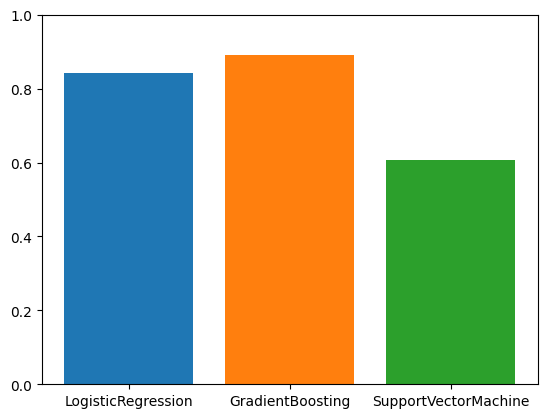

In [33]:
baseline = metrics["Baseline"]
for key, value in baseline.items():
    plt.bar(x=key, height=value["Test"][2])

plt.ylim(0.0, 1.0)

In [34]:
print(metrics["Baseline"]["GradientBoosting"]["Test"])
print(len(metrics["Baseline"]["GradientBoosting"]["Test"]))

(0.9017912316024642, 0.8887501392465463, 0.8910048503490721, nan)
4


## Baseline Model

In [35]:
X_train = clean_data(df_raw_trn)
X_test = clean_data(df_raw_tst)

label_to_int = {
    grade: i for
    i, grade in enumerate(
        reversed(class_labels))}
y_train = df_raw_trn[LABEL].map(label_to_int)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

gradient_boosting = XGBClassifier(random_state=SEED)
gradient_boosting.fit(X_train, y_train)

train_y_pred = gradient_boosting.predict(X_train)
test_y_pred = gradient_boosting.predict(X_test)

Prepare submission.

In [36]:
# print(test_y_pred.unique())
int_to_label = {
    i: grade for
    i, grade in enumerate(
        reversed(class_labels))}

df_submission = pd.DataFrame({
    ID: df_raw_tst[ID],
    LABEL: pd.Series(test_y_pred).map(int_to_label)
})
print(df_submission.groupby(LABEL).count())

SAVE_PATH = f"./submissions"
# df_submission.to_csv(
#     f"{SAVE_PATH}/{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv",
#     index=False)

         ID
grade      
A      1798
B      2968
C      2884
D      1471
E       648
F       179
G        52


In [37]:
print(df_raw_trn.columns.tolist())

['ID', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', '

## Feature Engineering

Time since loan is issued til last payment made in months.

In [38]:
issue_year = df_raw_trn['issue_d_year']
pay_year = df_raw_trn['last_pymnt_d_year']
issue_month = df_raw_trn['issue_d_month']
pay_month = df_raw_trn['last_pymnt_d_month']

loan_age_months = (pay_year - issue_year) * 12 + (pay_month - issue_month)
print(loan_age_months.describe())

count    10000.000000
mean        19.156700
std         12.238575
min          0.000000
25%          9.000000
50%         17.000000
75%         28.000000
max         62.000000
dtype: float64


Time since opening credit line til loan is issued.

In [39]:
credit_year = df_raw_trn['earliest_cr_line_year']
credit_month = df_raw_trn['earliest_cr_line_month']

credit_to_loan_months = (issue_year - credit_year) * 12 + (issue_month - credit_month)
print(credit_to_loan_months.describe())

count    10000.000000
mean       191.874500
std         85.433003
min         37.000000
25%        135.000000
50%        176.000000
75%        236.000000
max        618.000000
dtype: float64


Loan amount to yearly income ratio.

In [40]:
loan_amount = df_raw_trn['loan_amnt']
annual_income = df_raw_trn['annual_inc']

loan_income_ratio = loan_amount / annual_income
print(loan_income_ratio.describe())

count    10000.000000
mean         0.219461
std          0.138210
min          0.003200
25%          0.125000
50%          0.200000
75%          0.291667
max          3.833333
dtype: float64


Revolving balance to annual income ratio.

In [41]:
revol_balance = df_raw_trn['revol_bal']

revol_bal_to_income_ratio = revol_balance / annual_income
print(revol_bal_to_income_ratio.describe())

count    10000.000000
mean         0.219084
std          0.196151
min          0.000000
25%          0.096596
50%          0.175707
75%          0.288226
max          3.668540
dtype: float64


Percent of loan paid.

In [42]:
total_payment = df_raw_trn['total_pymnt']

percent_paid = total_payment / loan_amount
print(percent_paid.describe())

count    10000.000000
mean         0.818412
std          0.397545
min          0.020735
25%          0.431179
50%          1.014643
75%          1.135013
max          1.791058
dtype: float64


Outstanding principal to funded amount ratio.

In [43]:
outstanding_principal = df_raw_trn['out_prncp']
funded_amount = df_raw_trn['funded_amnt']

remaining_principal_ratio = outstanding_principal / funded_amount
print(remaining_principal_ratio.describe())

count    10000.000000
mean         0.265442
std          0.353536
min          0.000000
25%          0.000000
50%          0.000000
75%          0.614354
max          0.987607
dtype: float64


In [44]:
installment = df_raw_trn['installment']

installment_to_income_ratio = installment / annual_income
print(installment_to_income_ratio.describe())

count    10000.000000
mean         0.006546
std          0.004044
min          0.000113
25%          0.003831
50%          0.005872
75%          0.008505
max          0.089176
dtype: float64


In [45]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    issue_year = df['issue_d_year']
    pay_year = df['last_pymnt_d_year']
    issue_month = df['issue_d_month']
    pay_month = df['last_pymnt_d_month']
    loan_age_months = (pay_year - issue_year) * 12 + (pay_month - issue_month)

    credit_year = df_raw_trn['earliest_cr_line_year']
    credit_month = df_raw_trn['earliest_cr_line_month']
    credit_to_loan_months = (issue_year - credit_year) * 12 + (issue_month - credit_month)

    loan_amount = df_raw_trn['loan_amnt']
    annual_income = df_raw_trn['annual_inc']
    loan_income_ratio = loan_amount / annual_income

    revol_balance = df_raw_trn['revol_bal']
    revol_bal_to_income_ratio = revol_balance / annual_income

    total_payment = df_raw_trn['total_pymnt']
    percent_paid = total_payment / loan_amount

    outstanding_principal = df_raw_trn['out_prncp']
    funded_amount = df_raw_trn['funded_amnt']
    remaining_principal_ratio = outstanding_principal / funded_amount

    installment = df_raw_trn['installment']
    installment_to_income_ratio = installment / annual_income

    new_df = df.copy()
    new_df["loan_age_months"] = loan_age_months
    new_df["credit_to_loan_months"] = credit_to_loan_months
    new_df["loan_income_ratio"] = loan_income_ratio
    new_df["revol_bal_to_income_ratio"] = revol_bal_to_income_ratio
    new_df["percent_paid"] = percent_paid
    new_df["remaining_principal_ratio"] = remaining_principal_ratio
    new_df["installment_to_income_ratio"] = installment_to_income_ratio

    return new_df

In [46]:
df_features = df_raw_trn.copy()
df_features["loan_age_months"] = loan_age_months
df_features["credit_to_loan_months"] = credit_to_loan_months
df_features["loan_income_ratio"] = loan_income_ratio
df_features["revol_bal_to_income_ratio"] = revol_bal_to_income_ratio
df_features["percent_paid"] = percent_paid
df_features["remaining_principal_ratio"] = remaining_principal_ratio
df_features["installment_to_income_ratio"] = installment_to_income_ratio

df = clean_data(df_features)
df[LABEL] = df_features[LABEL]
# print(df.columns[df.isna().any()].tolist())
print(df.shape)

label_to_int = {
grade: i for
i, grade in enumerate(
    reversed(class_labels))}
df[LABEL] = df_features[LABEL].map(label_to_int)

train_cv_dfs, test_cv_dfs = prepare_cv_datasets(df)

(10000, 107)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Fitting 3 folds for each of 32 candidates, totalling 96 fits


Training Precision  Training Recall  Training F1
0            0.994448         0.990463      0.99237

Test Precision  Test Recall   Test F1
0        0.911636     0.894338  0.897897

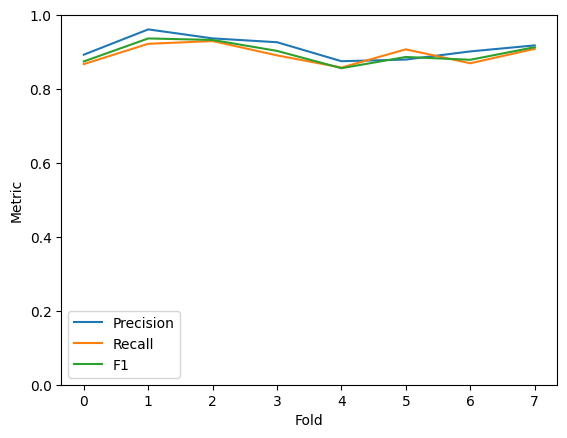

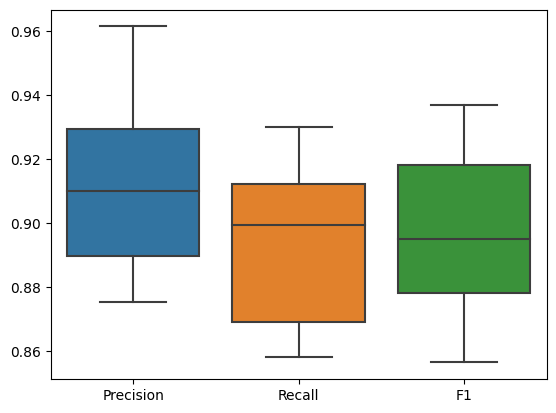

In [47]:
train_performance_xgb = np.empty((len(SEEDS), 4))
test_performance_xgb = np.empty((len(SEEDS), 4))

parameter_grid = {
    'n_estimators': [70, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}
    # 'min_child_weight': [3, 7]}

for i, fold in enumerate(zip(train_cv_dfs, test_cv_dfs)):
    X_train, y_train = fold[0]
    X_test, y_test = fold[1]

    gradient_boosting = XGBClassifier(
        random_state=SEED,
        gamma=1,
        reg_alpha=0.1,
        reg_lambda=1)
    grid = GridSearchCV(
        estimator=gradient_boosting,
        param_grid=parameter_grid,
        scoring="f1_macro",
        cv=3,
        verbose=1)
    grid.fit(X_train, y_train)
    # gradient_boosting.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_fold_performance = precision_recall_fscore_support(
        y_train, y_train_pred, average="macro")
    test_fold_performance = precision_recall_fscore_support(
        y_test, y_test_pred, average="macro")
    
    train_performance_xgb[i] = train_fold_performance
    test_performance_xgb[i] = test_fold_performance

train_performance_xgb_mean = train_performance_xgb.mean(axis=0)
test_performance_xgb_mean = test_performance_xgb.mean(axis=0)
display_performance(train_performance_xgb_mean, label="Training")
display_performance(test_performance_xgb_mean, label="Test")

plt.plot(test_performance_xgb[:, 0], label="Precision")
plt.plot(test_performance_xgb[:, 1], label="Recall")
plt.plot(test_performance_xgb[:, 2], label="F1")
plt.xticks(range(test_performance_xgb.shape[0]))
plt.ylabel("Metric")
plt.xlabel("Fold")
plt.ylim(0.0, 1.0)
plt.legend()

plt.figure()
ax = sns.boxplot(test_performance_xgb[:, :-1])
ax.set_xticklabels(["Precision", "Recall", "F1"])
ticks = plt.xticks()[0]

step = "FeatureEngineering"
metrics[step] = {}
metrics[step]["GradientBoosting"] = {}
metrics[step]["GradientBoosting"]["Train"] = tuple(train_performance_xgb_mean)
metrics[step]["GradientBoosting"]["Test"] = tuple(test_performance_xgb_mean)

# 0.901791    0.88875    0.891005

In [51]:
df_feat_trn = add_features(df_raw_trn)
df_feat_tst = add_features(df_raw_tst)

X_train = clean_data(df_feat_trn)
X_test = clean_data(df_feat_tst)

label_to_int = {
    grade: i for
    i, grade in enumerate(
        reversed(class_labels))}
y_train = df_raw_trn[LABEL].map(label_to_int)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


gradient_boosting = XGBClassifier(random_state=SEED)
grid = GridSearchCV(
    estimator=gradient_boosting,
    param_grid=parameter_grid,
    scoring="f1_macro",
    cv=5,
    verbose=1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

train_feat_y_pred = best_model.predict(X_train)
test_feat_y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [52]:
print((test_y_pred != test_feat_y_pred).sum())

34


In [53]:
# print(test_y_pred.unique())
int_to_label = {
    i: grade for
    i, grade in enumerate(
        reversed(class_labels))}

df_submission = pd.DataFrame({
    ID: df_raw_tst[ID],
    LABEL: pd.Series(test_feat_y_pred).map(int_to_label)
})
print(df_submission.groupby(LABEL).count())

SAVE_PATH = f"./submissions"
df_submission.to_csv(
    f"{SAVE_PATH}/{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv",
    index=False)

         ID
grade      
A      1798
B      2974
C      2878
D      1470
E       651
F       180
G        49
